In [87]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm

# Load and filter data
round_slots = pd.read_csv("../data/MNCAATourneySlots.csv")
round_slots = round_slots[round_slots['Season'] == 2023]
round_slots = round_slots[round_slots['Slot'].str.contains('R')] # Filter out First Four

seeds = pd.read_csv("../data/2024_tourney_seeds.csv")
seeds_m = seeds[seeds['Tournament'] == 'M']
seeds_w = seeds[seeds['Tournament'] == 'W']

# preds = pd.read_csv("../submissions/sub1_3_13.csv")
preds = pd.read_csv("../submissions/sub_2023_in_2024.csv")

preds['ID'] = preds['ID'].str.split('_')


In [88]:
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []

    for slot, strong, weak in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed):
        team_1, team_2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team_1)][str(team_2)]
            
        if sim:
            # Randomly determine the winner based on the probability
            winner = np.random.choice([team_1, team_2], p=[proba, 1 - proba])
        else:
            # Determine the winner based on the higher probability
            winner = [team_1, team_2][np.argmax([proba, 1-proba])]
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets+1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, sim)
        
        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df


In [101]:
n_brackets = 10000
result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=True)
result_m['Tournament'] = 'M'
# result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=True)
# result_w['Tournament'] = 'W'
# submission = pd.concat([result_m, result_w])
# submission.reset_index(inplace=True, drop=True)
# submission.index.names = ['RowId']

  0%|          | 22/10000 [00:00<00:46, 213.99it/s]

100%|██████████| 10000/10000 [00:19<00:00, 505.57it/s]


In [102]:
# Add TeamID and name
m_seeds = pd.read_csv("../data/MNCAATourneySeeds.csv")[["Seed", "Season", "TeamID"]]
m_seeds = m_seeds[m_seeds.Season == 2023]
m_seeds.columns = ["Team", "Season", "TeamID"]
result_m = result_m.merge(m_seeds, how="left", on="Team")
teams = pd.read_csv("../data/MTeams.csv")
teams["TeamID"] = teams["TeamID"].astype(float)
result_m = result_m.merge(teams, how="left", on="TeamID")
result_m["Round"] = result_m.Slot.str[1].astype(int)



In [103]:
result_m["Quadrant"] = result_m.Slot.str[2]


### Sample charts

/var/folders/2g/465yxy_x4g786jx2llr5xqh40000gn/T/ipykernel_7039/2497982467.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(champion_sim.index, rotation=45)


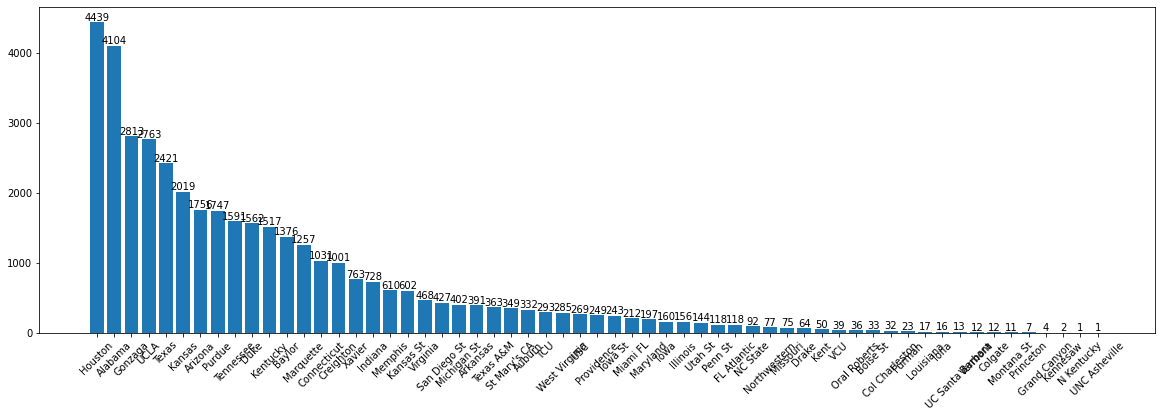

In [104]:
### Sample charts

champions = result_m[result_m.Round == 4]
champion_sim = pd.DataFrame(champions["TeamName"].value_counts())

from matplotlib import pyplot as plt
# plt.figure(figsize=(20, 6))
# plt.bar(champion_sim.index, champion_sim['champion'])

fig, ax = plt.subplots(figsize=(20, 6))
bar_container = ax.bar(champion_sim.index, champion_sim['TeamName'])
ax.bar_label(bar_container)
ax.set_xticklabels(champion_sim.index, rotation=45)
ax.tick_params(axis='x', rotation=45)

In [94]:
result_m

,Bracket,Slot,Team,Tournament,Season,TeamID,TeamName,FirstD1Season,LastD1Season,Round,Quadrant
0,1,R1W1,W01,M,2023.0,1345.0,Purdue,1985.0,2024.0,1,W
1,1,R1W2,W02,M,2023.0,1266.0,Marquette,1985.0,2024.0,1,W
2,1,R1W3,W03,M,2023.0,1243.0,Kansas St,1985.0,2024.0,1,W
3,1,R1W4,W04,M,2023.0,1397.0,Tennessee,1985.0,2024.0,1,W
4,1,R1W5,W05,M,2023.0,1181.0,Duke,1985.0,2024.0,1,W
...,...,...,...,...,...,...,...,...,...,...,...
314995,5000,R4Y1,Y04,M,2023.0,1231.0,Indiana,1985.0,2024.0,4,Y
314996,5000,R4Z1,Z02,M,2023.0,1417.0,UCLA,1985.0,2024.0,4,Z
314997,5000,R5WX,X03,M,2023.0,1124.0,Baylor,1985.0,2024.0,5,W
314998,5000,R5YZ,Z02,M,2023.0,1417.0,UCLA,1985.0,2024.0,5,Y


/var/folders/2g/465yxy_x4g786jx2llr5xqh40000gn/T/ipykernel_7039/703824948.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(champion_sim.index, rotation=45)


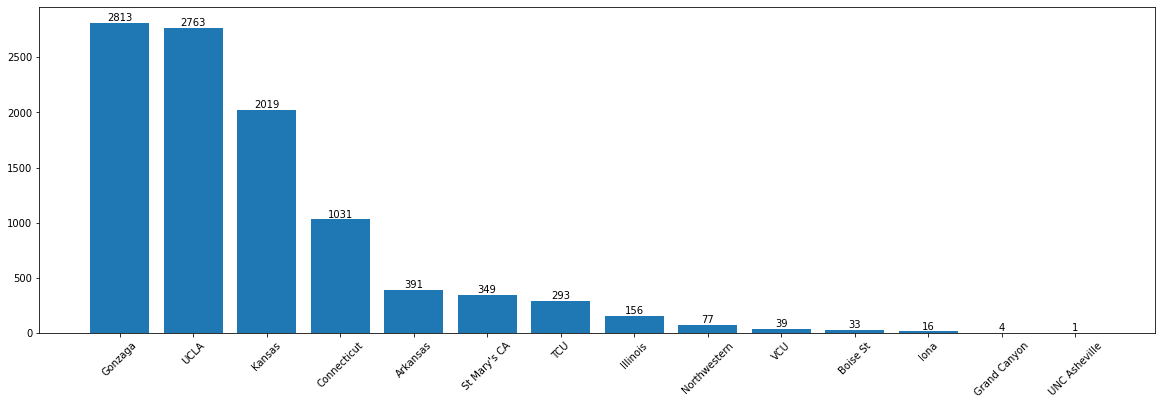

In [107]:
# distribution for a single quad (we should be able to turn this into a function)

champions = result_m[result_m.Round == 4]
champions = champions[champions.Quadrant == "Z"]
champion_sim = pd.DataFrame(champions["TeamName"].value_counts())

fig, ax = plt.subplots(figsize=(20, 6))
bar_container = ax.bar(champion_sim.index, champion_sim['TeamName'])
ax.bar_label(bar_container)
ax.set_xticklabels(champion_sim.index, rotation=45)
ax.tick_params(axis='x', rotation=45)